# Compare all faces in an image with Amazon Rekognition againt your collection

The following notebook will guide you through on how to compare all faces detected in an image against your Amazon Rekognition Face Collection. 

In [17]:
import boto3, json, os, io
from PIL import Image
client=boto3.client('rekognition')

## View your existing collections

In [18]:
def list_collections():

    max_results=10
    
    #Display all the collections
    print('Displaying collections...')
    response=client.list_collections(MaxResults=max_results)
    collection_count=0
    done=False
    
    while done==False:
        collections=response['CollectionIds']

        for collection in collections:
            print (collection)
            collection_count+=1
        if 'NextToken' in response:
            nextToken=response['NextToken']
            response=client.list_collections(NextToken=nextToken,MaxResults=max_results)
            
        else:
            done=True

    return collection_count   

collection_count=list_collections()
print("collections: " + str(collection_count))


Displaying collections...
collections: 0


## Create a new collection

In [19]:
collection_id='Avengers_Collection' # Remember you must use a unique name if you are creating a new collection

In [20]:
def create_collection(collection_id):
    #Create a collection
    print('Creating collection:' + collection_id)
    response=client.create_collection(CollectionId=collection_id)
    print('Collection ARN: ' + response['CollectionArn'])
    print('Status code: ' + str(response['StatusCode']))
    print('Done...')
    
create_collection(collection_id)

Creating collection:Avengers_Collection
Collection ARN: aws:rekognition:eu-west-1:238023316787:collection/Avengers_Collection
Status code: 200
Done...


## Confirm your collection creation

In [6]:
collection_count=list_collections()
print("collections: " + str(collection_count))

Displaying collections...
Avengers_Collection
collections: 1


## Add faces to a collection

### Download collection images

In [7]:
!curl http://dz4iesrkqs7j9.cloudfront.net/random/avengers_face_search.zip -O
!unzip avengers_face_search.zip
!rm -R __MACOSX
!rm avengers_face_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2279k  100 2279k    0     0  76.7M      0 --:--:-- --:--:-- --:--:-- 76.7M
Archive:  avengers_face_search.zip
   creating: avengers_face_search/
   creating: avengers_face_search/test/
   creating: avengers_face_search/populate/
  inflating: avengers_face_search/test/Avengers_test_1.jpg  
  inflating: __MACOSX/avengers_face_search/test/._Avengers_test_1.jpg  
  inflating: avengers_face_search/test/Avengers_test_2.jpg  
  inflating: __MACOSX/avengers_face_search/test/._Avengers_test_2.jpg  
  inflating: avengers_face_search/test/Avengers_test_3.jpg  
  inflating: __MACOSX/avengers_face_search/test/._Avengers_test_3.jpg  
  inflating: avengers_face_search/populate/Nebula.jpg  
  inflating: __MACOSX/avengers_face_search/populate/._Nebula.jpg  
  inflating: avengers_face_search/populate/Ant_Man.jpg  
  inflating: __MACOSX/avengers

### Iterate over files in population folder and index faces

In [21]:
directory = 'avengers_face_search/populate'
 
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        print(f)
        file = open(f, "rb") # opening for [r]eading as [b]inary
        data = file.read() 
        response=client.index_faces(CollectionId=collection_id,
                            Image={'Bytes':data},
                            ExternalImageId=f.split("/")[2],
                            MaxFaces=1,
                            QualityFilter="AUTO",
                            DetectionAttributes=['ALL'])
        print ('Results for ' + f.split("/")[2])
        print('Faces indexed:')
        for faceRecord in response['FaceRecords']:
            print('  Face ID: ' + faceRecord['Face']['FaceId'])
            print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))

        print('Faces not indexed:')
        for unindexedFace in response['UnindexedFaces']:
            print(' Location: {}'.format(unindexedFace['FaceDetail']['BoundingBox']))
            print(' Reasons:')
            for reason in unindexedFace['Reasons']:
                print('   ' + reason)
        file.close()


avengers_face_search/populate/Captain_America.jpg
Results for Captain_America.jpg
Faces indexed:
  Face ID: 0a19a158-93a6-4e0d-acde-b88060a5cad0
  Location: {'Width': 0.179216206073761, 'Height': 0.3197809159755707, 'Left': 0.3152351379394531, 'Top': 0.07362963259220123}
Faces not indexed:
avengers_face_search/populate/Thor.jpg
Results for Thor.jpg
Faces indexed:
  Face ID: 1bbc85ef-64c5-4f50-b338-34d10874feeb
  Location: {'Width': 0.306733638048172, 'Height': 0.5414182543754578, 'Left': 0.36272162199020386, 'Top': 0.09976422041654587}
Faces not indexed:
avengers_face_search/populate/Iron_Man.jpg
Results for Iron_Man.jpg
Faces indexed:
  Face ID: 428cb8b9-2a0e-4b28-8aaf-a353fceb1cfb
  Location: {'Width': 0.24355801939964294, 'Height': 0.5599427223205566, 'Left': 0.45351096987724304, 'Top': 0.19145916402339935}
Faces not indexed:
avengers_face_search/populate/Nebula.jpg
Results for Nebula.jpg
Faces indexed:
  Face ID: d8ad4e98-2417-4f33-a76d-8cc3849e216a
  Location: {'Width': 0.18391683

## List faces in the collection

In [22]:
def list_faces_in_collection(collection_id):

    maxResults=20
    faces_count=0
    tokens=True

    response=client.list_faces(CollectionId=collection_id,
                               MaxResults=maxResults)

    print('Faces in collection ' + collection_id)
 
    while tokens:

        faces=response['Faces']

        for face in faces:
            print (face["FaceId"],face["ExternalImageId"].split('.')[0])
            faces_count+=1
        if 'NextToken' in response:
            nextToken=response['NextToken']
            response=client.list_faces(CollectionId=collection_id,
                                       NextToken=nextToken,MaxResults=maxResults)
        else:
            tokens=False
    return faces_count   

faces_count=list_faces_in_collection(collection_id)
print("Faces in collection: " + str(faces_count))

Faces in collection Avengers_Collection
048386aa-2c03-48c7-b7a0-fdc1beba6378 Black_Widow
0a19a158-93a6-4e0d-acde-b88060a5cad0 Captain_America
1026165c-6073-44fb-986d-b2f9615712e8 Hulk
10bf536a-bd17-4dd8-85c9-3f661aad88e7 War_Machine
1bbc85ef-64c5-4f50-b338-34d10874feeb Thor
428cb8b9-2a0e-4b28-8aaf-a353fceb1cfb Iron_Man
94babced-4f77-466c-90ef-f81b6a94a0c4 Ant_Man
9ee8d98c-b8df-4343-8dd7-8454b4cba851 Dora_Milaje
d8ad4e98-2417-4f33-a76d-8cc3849e216a Nebula
e1de2a1a-c940-4c0c-939c-b8521f052c49 Captain_Marvel
Faces in collection: 10


## Find faces in photo

In [32]:
def transform_bounding(img, box):
    imgWidth, imgHeight = img.size
    l = (imgWidth * box['Left'])-5
    t = (imgHeight * box['Top'])-5
    w = (imgWidth * box['Width'])+10
    h = (imgHeight * box['Height'])+10
    return l,t,w,h

In [33]:
def detect_faces(file):
    faces = []
    f = open(file, "rb") # opening for [r]eading as [b]inary
    data = f.read() 
    response = client.detect_faces(Image={'Bytes':data})
    for face in response["FaceDetails"]:
        faces.append(face['BoundingBox'])
    print("Faces detected: " + str(len(response['FaceDetails'])))   
    return faces

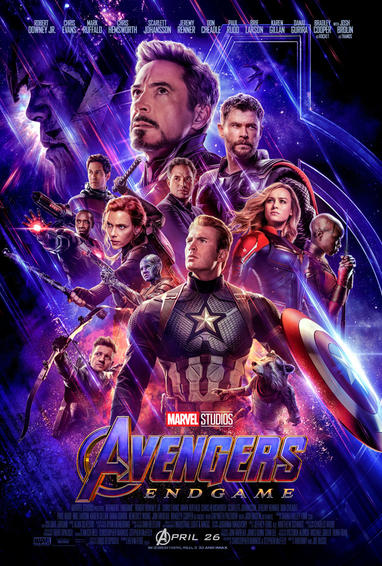

Faces detected: 10
face found


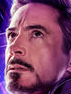

Character:Iron_Man
Similarity: 99.65%
------------------------------
face found


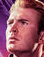

Character:Captain_America
Similarity: 75.44%
------------------------------
face found


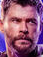

Character:Thor
Similarity: 99.96%
------------------------------
face found


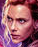

Character:Black_Widow
Similarity: 90.58%
------------------------------
face found


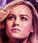

Character:Captain_Marvel
Similarity: 99.57%
------------------------------
face found


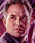

Character:Hulk
Similarity: 65.88%
------------------------------
face found


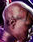

but no match found
------------------------------
face found


Character:Ant_Man
Similarity: 92.77%
------------------------------
face found


but no match found
------------------------------
face found


Character:War_Machine
Similarity: 96.12%
------------------------------


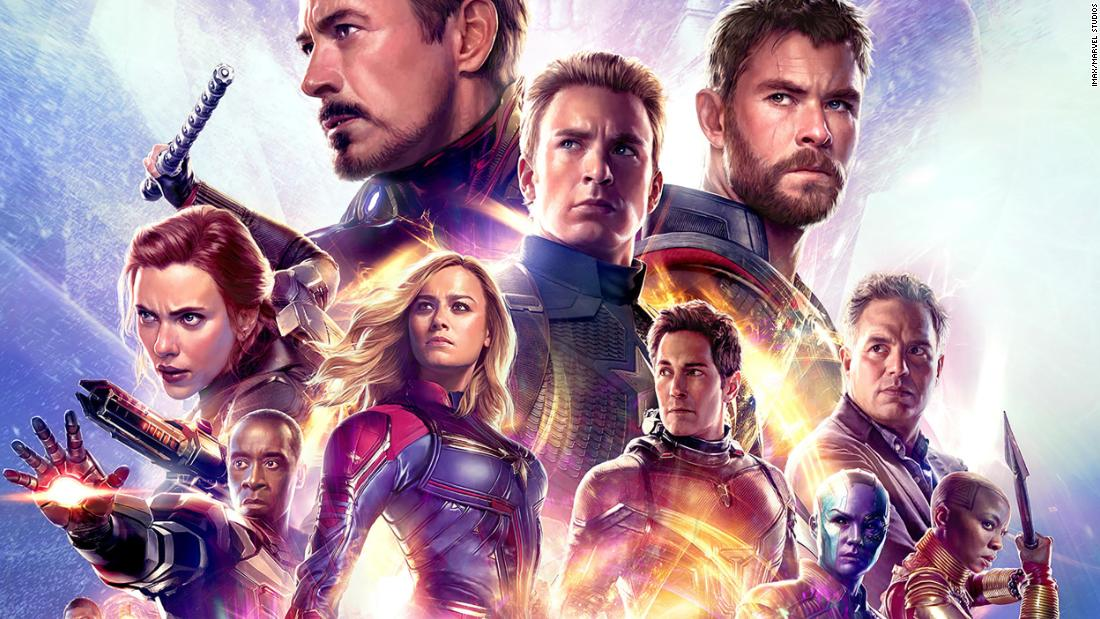

Faces detected: 10
face found


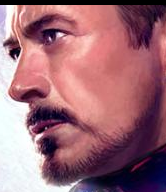

Character:Iron_Man
Similarity: 68.20%
------------------------------
face found


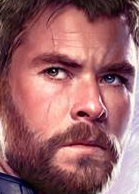

Character:Thor
Similarity: 99.96%
------------------------------
face found


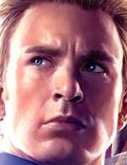

Character:Captain_America
Similarity: 99.77%
------------------------------
face found


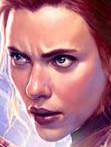

Character:Black_Widow
Similarity: 95.72%
------------------------------
face found


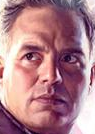

Character:Hulk
Similarity: 98.71%
------------------------------
face found


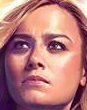

Character:Captain_Marvel
Similarity: 99.95%
------------------------------
face found


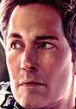

Character:Ant_Man
Similarity: 98.83%
------------------------------
face found


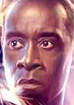

Character:War_Machine
Similarity: 99.99%
------------------------------
face found


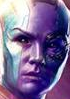

Character:Nebula
Similarity: 97.86%
------------------------------
face found


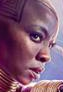

Character:Dora_Milaje
Similarity: 99.98%
------------------------------


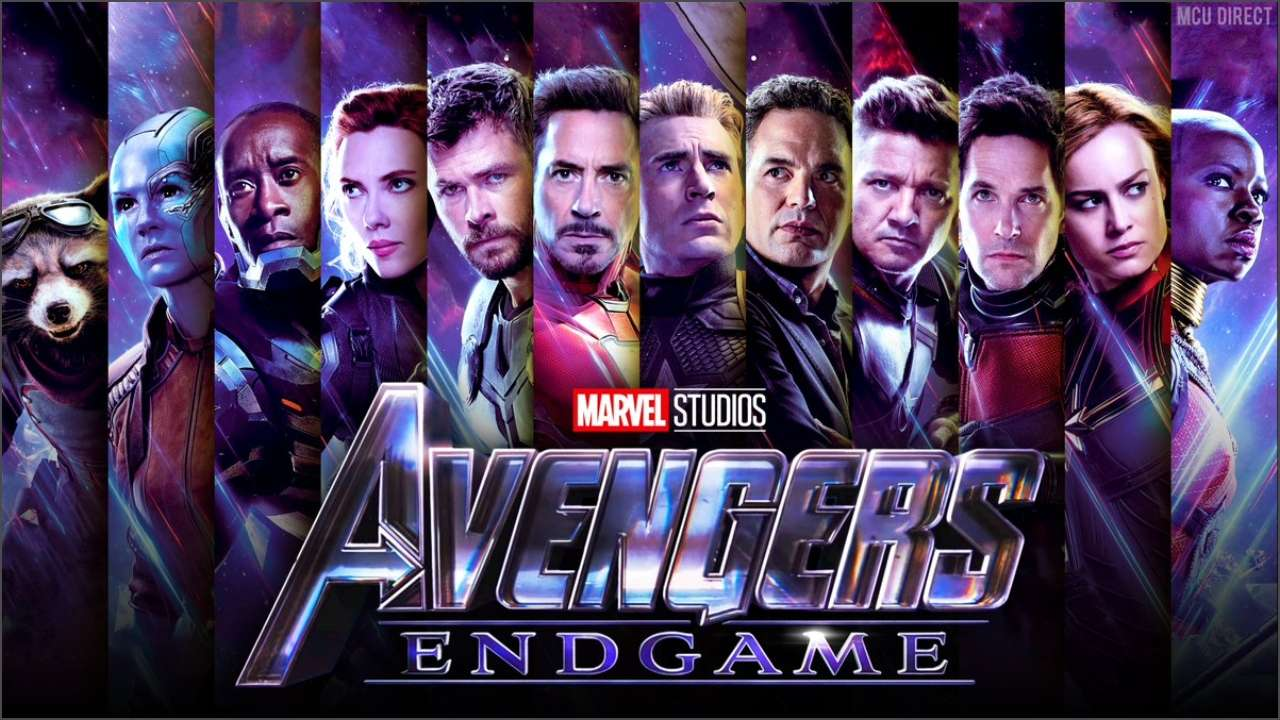

Faces detected: 11
face found


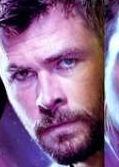

Character:Thor
Similarity: 100.00%
------------------------------
face found


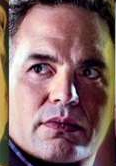

Character:Hulk
Similarity: 99.29%
------------------------------
face found


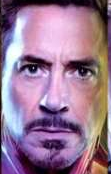

Character:Iron_Man
Similarity: 97.93%
------------------------------
face found


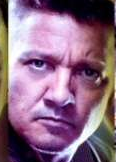

but no match found
------------------------------
face found


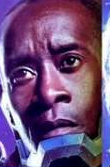

Character:War_Machine
Similarity: 99.99%
------------------------------
face found


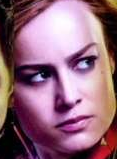

Character:Captain_Marvel
Similarity: 100.00%
------------------------------
face found


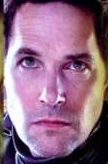

Character:Ant_Man
Similarity: 99.96%
------------------------------
face found


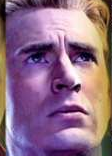

Character:Captain_America
Similarity: 94.14%
------------------------------
face found


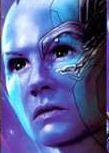

Character:Nebula
Similarity: 74.47%
------------------------------
face found


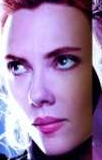

Character:Black_Widow
Similarity: 93.95%
------------------------------
face found


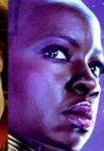

Character:Dora_Milaje
Similarity: 99.93%
------------------------------


In [34]:
directory = 'avengers_face_search/test'
 
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img = Image.open(f)
        img.show()
        faces = detect_faces(f)        
        for face in faces:
            l,t,w,h = transform_bounding(img,face)
            cropped = img.crop((l,t,l+w,t+h))    

            stream = io.BytesIO()
            cropped.save(stream, format='JPEG')
            bin_img = stream.getvalue()

            response0 = client.detect_faces(
                Image={'Bytes': bin_img},
            )

            if len(response0['FaceDetails']) > 0:
                print("face found")
                cropped.show()
                response1=client.search_faces_by_image(CollectionId="Avengers_Collection",
                                                  Image={'Bytes': bin_img},
                                                  FaceMatchThreshold=50)
                faceMatches=response1['FaceMatches']
                if(len(faceMatches) > 0):
                    for match in faceMatches:
                        print ('Character:' + match['Face']['ExternalImageId'].split('.')[0])
                        print ('Similarity: ' + "{:.2f}".format(match['Similarity']) + "%")
                else:
                    print("but no match found")
            else:
                print("face not found in the following crop")
                cropped.show()

            print("------------------------------")  

## Clean up the resources

Delete your face collection 

In [13]:
def delete_collection(collection_id):


    print('Attempting to delete collection ' + collection_id)
    client=boto3.client('rekognition')
    status_code=0
    try:
        response=client.delete_collection(CollectionId=collection_id)
        status_code=response['StatusCode']
        
    except ClientError as e:
        if e.response['Error']['Code'] == 'ResourceNotFoundException':
            print ('The collection ' + collection_id + ' was not found ')
        else:
            print ('Error other than Not Found occurred: ' + e.response['Error']['Message'])
        status_code=e.response['ResponseMetadata']['HTTPStatusCode']
    return(status_code)


def main():
    collection_id='Avengers_Collection'
    status_code=delete_collection(collection_id)
    print('Status code: ' + str(status_code))

if __name__ == "__main__":
    main()  

Attempting to delete collection Avengers_Collection
Status code: 200
